# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

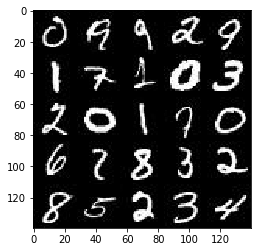

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

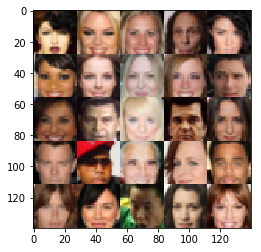

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    shape = (None, image_width, image_height, image_channels)
    real_inputs = tf.placeholder(tf.float32, shape = shape, name='real_inputs')
    z_data      = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, shape=(None),  name='learning_rate')
    return real_inputs, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)

        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generate_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generate_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generate_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    return discriminator_loss, generate_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    batch, image_width, image_height, image_channels = data_shape
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    batch_count = 0
    n_images = 64
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                dis = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                gen = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                batch_count += 1
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 3.0856... Generator Loss: 0.0617
Epoch 1/2... Discriminator Loss: 0.1665... Generator Loss: 3.0789
Epoch 1/2... Discriminator Loss: 0.1658... Generator Loss: 2.4844
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 3.4635
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.3808... Generator Loss: 1.9775
Epoch 1/2... Discriminator Loss: 0.1560... Generator Loss: 3.2949
Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 3.9857
Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 3.5797


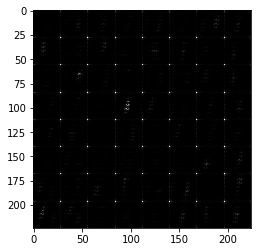

Epoch 1/2... Discriminator Loss: 1.7557... Generator Loss: 8.4783
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 1.4683
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 4.4567
Epoch 1/2... Discriminator Loss: 0.4177... Generator Loss: 2.7314
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 3.0548


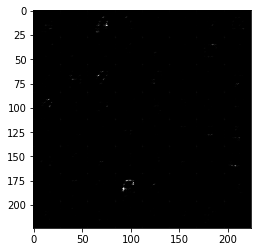

Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 2.6657
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 2.9920
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.3451
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 3.4807
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.6000
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.4239


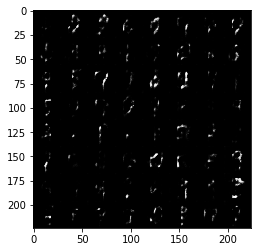

Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.4807
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 3.0420
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 1.9637
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.5479
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 1.7708


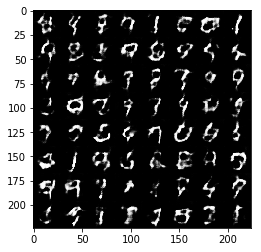

Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 0.7726... Generator Loss: 1.1288
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 1.9447
Epoch 1/2... Discriminator Loss: 0.7706... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 0.8563


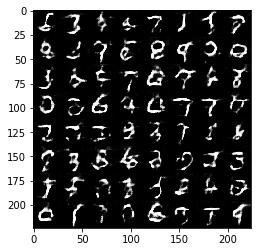

Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 1.5208
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 1.1380
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.3690
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.8376
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 1.8146
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 2.1403
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.2850
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.8079


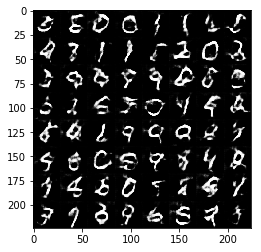

Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.8977
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 2.4586


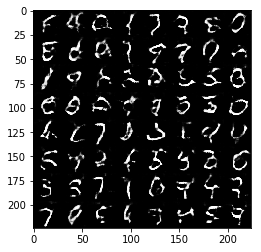

Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 3.8433
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.0933
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 3.0681
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.1938
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.6971


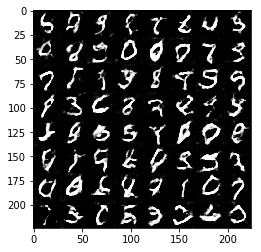

Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.9232
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 0.9416
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.6171


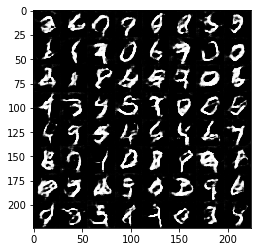

Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.4903
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.8768
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 1.6526
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.2144
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.1145
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.3951


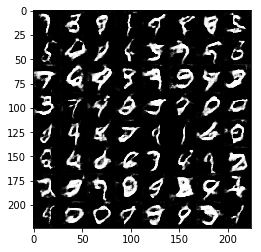

Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 1.7716
Epoch 2/2... Discriminator Loss: 2.3997... Generator Loss: 3.2354
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.6394
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.6665... Generator Loss: 2.9727
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.4239


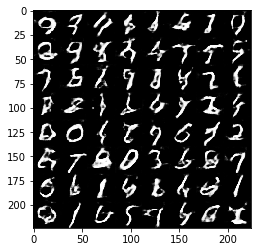

Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.4620
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.3664
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.6809... Generator Loss: 0.3477
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 0.3817


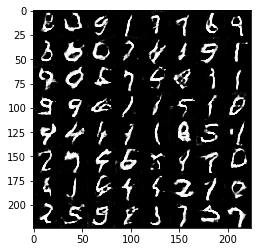

Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 2.3183
Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 1.7053
Epoch 2/2... Discriminator Loss: 2.0237... Generator Loss: 0.2128
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 0.6693
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.6612
Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 1.4931
Epoch 2/2... Discriminator Loss: 2.2346... Generator Loss: 4.1442


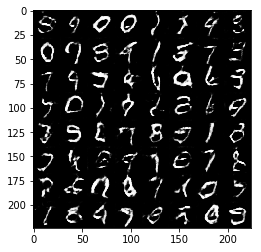

Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 2.2134
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 1.3345
Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 2.3358
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.7731
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.4548
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 0.8894


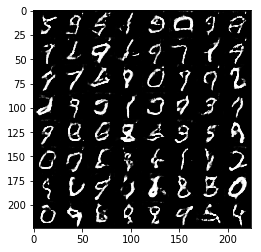

Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 2.4558
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 2.4920
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 3.2048
Epoch 2/2... Discriminator Loss: 0.6226... Generator Loss: 1.7139
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 1.6559
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.4123
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 3.7920... Generator Loss: 0.0370


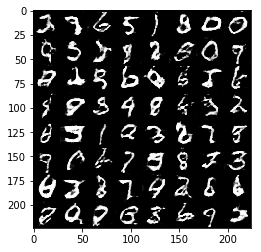

Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.5608
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.5353
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 2.1466
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.6512
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 1.1907
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 0.7855


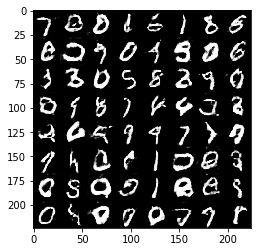

Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 4.2095
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 2.0441
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.1391


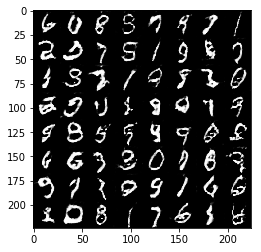

Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 1.6357... Generator Loss: 3.1995
Epoch 2/2... Discriminator Loss: 1.7868... Generator Loss: 2.4608
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 2.7568
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.9065
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.4850


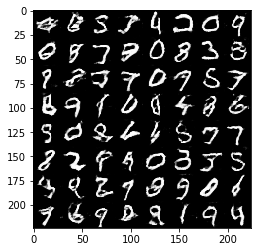

Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.4295
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.5499


In [ ]:
batch_size = 64
z_dim = 120
learning_rate = 0.0006
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 11.2201
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 20.0126
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 10.5709
Epoch 1/1... Discriminator Loss: 0.2336... Generator Loss: 11.7253
Epoch 1/1... Discriminator Loss: 0.1610... Generator Loss: 6.0396
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 2.4033... Generator Loss: 6.6699


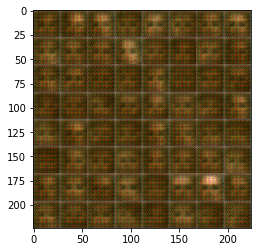

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 10.3893
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 2.5236
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 6.0714
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 6.1006
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 5.6027
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 2.6085


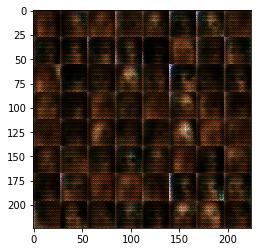

Epoch 1/1... Discriminator Loss: 2.0634... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 0.3251... Generator Loss: 2.5185
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 2.2210
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 1.5045
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.9455


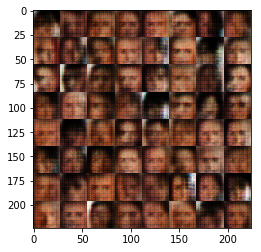

Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.6369
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 4.6922
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6088


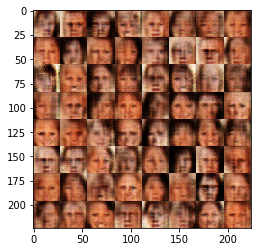

Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 5.1419
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.4516


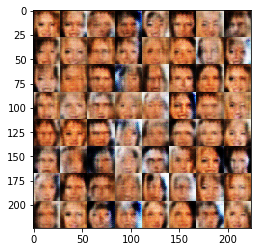

Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 2.0111
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.1468
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.1296


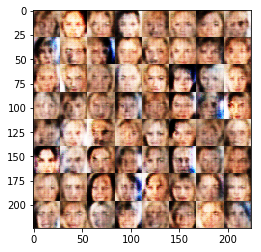

Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 3.0739
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 2.9949
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.6820
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.2976
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 2.1576
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.0853


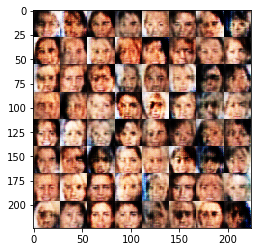

Epoch 1/1... Discriminator Loss: 0.2474... Generator Loss: 2.1840
Epoch 1/1... Discriminator Loss: 0.3194... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 0.2135... Generator Loss: 3.5420
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 4.4527
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 3.0763
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 2.1869
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 2.7737
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.9110


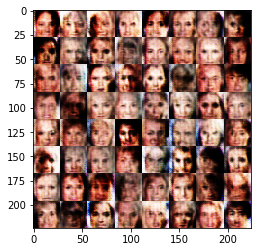

Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 3.1013
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 3.3534
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.8304
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 3.1614
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 2.5037
Epoch 1/1... Discriminator Loss: 0.2134... Generator Loss: 2.2641
Epoch 1/1... Discriminator Loss: 0.2169... Generator Loss: 2.6803


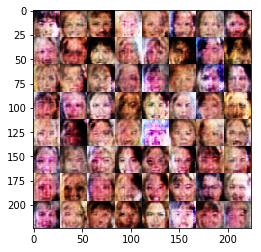

Epoch 1/1... Discriminator Loss: 0.2484... Generator Loss: 2.2752
Epoch 1/1... Discriminator Loss: 2.4802... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 5.9177
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.7658
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 5.8486
Epoch 1/1... Discriminator Loss: 1.8007... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.0290


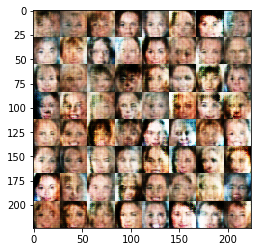

Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.3045... Generator Loss: 3.8578
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 0.2482... Generator Loss: 2.2311
Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 3.5995
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.0140
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.1993


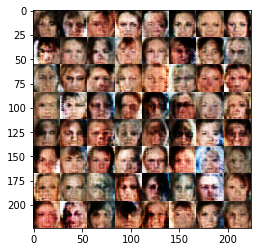

Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 4.5298
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.2965... Generator Loss: 2.5796
Epoch 1/1... Discriminator Loss: 0.2063... Generator Loss: 4.2403
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.2488... Generator Loss: 2.6128


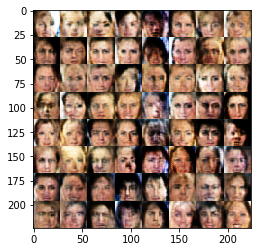

Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 1.6417
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 3.3133
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 2.2413
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.5422
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 3.7590
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 1.9693


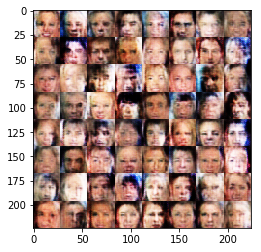

Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.9116
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.7726


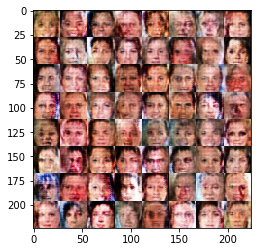

Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 2.2265
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 4.5120
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 2.9713
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 2.0458


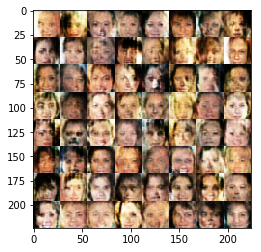

Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 3.3169
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 3.3563
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 3.3478
Epoch 1/1... Discriminator Loss: 0.1376... Generator Loss: 3.3198
Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 3.5786
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 1.7912
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 2.9761


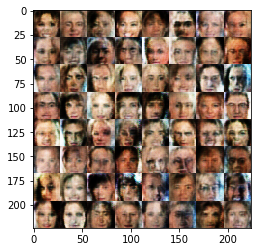

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 3.7092
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 2.6022
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 3.8298
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.8634
Epoch 1/1... Discriminator Loss: 2.0945... Generator Loss: 4.0069


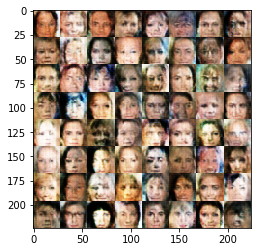

Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 2.7955
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 3.1374
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.7803... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 1.5463


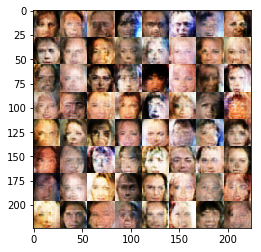

Epoch 1/1... Discriminator Loss: 0.2842... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 2.4208
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 2.9130
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 3.2594
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.6948
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 3.0014
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.7472


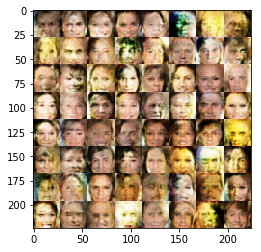

Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 3.9623
Epoch 1/1... Discriminator Loss: 1.9958... Generator Loss: 5.3113
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 3.1096
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 2.1488
Epoch 1/1... Discriminator Loss: 0.3021... Generator Loss: 4.0134
Epoch 1/1... Discriminator Loss: 0.1513... Generator Loss: 2.6113
Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 2.8348
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 3.1793


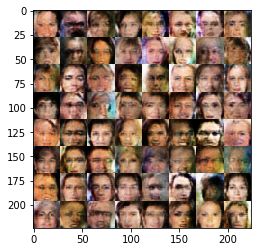

Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.7171
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 2.8872
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 4.2359
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 4.4839


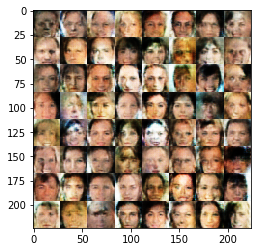

Epoch 1/1... Discriminator Loss: 1.9984... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 2.8221
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 3.0413
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 2.7032
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.9479
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.0939


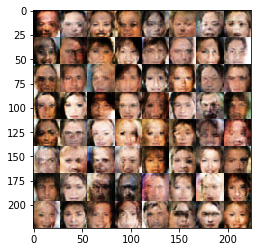

Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 5.0419
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.6966
Epoch 1/1... Discriminator Loss: 0.2576... Generator Loss: 4.6629
Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 2.5255
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.1746
Epoch 1/1... Discriminator Loss: 4.3437... Generator Loss: 0.0306


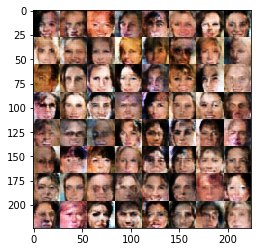

Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 3.2964
Epoch 1/1... Discriminator Loss: 0.2095... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 4.1822
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.3137
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 2.3427
Epoch 1/1... Discriminator Loss: 0.2469... Generator Loss: 2.3156


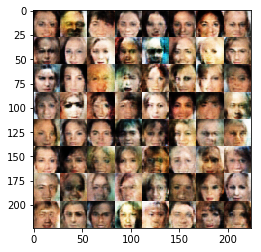

Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 2.0265
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 3.7781
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 3.0528
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.8989
Epoch 1/1... Discriminator Loss: 0.2871... Generator Loss: 3.3991
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 4.0545
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 4.3124


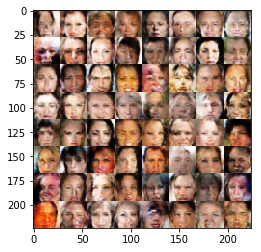

Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 2.4276
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.1645
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 2.5649
Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 4.5702
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 2.8510


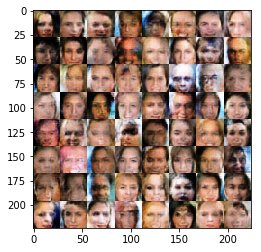

Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 4.0175
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 3.7631... Generator Loss: 0.0494
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.4882
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 2.7280
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 4.1211
Epoch 1/1... Discriminator Loss: 0.2602... Generator Loss: 2.4325
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 3.4422


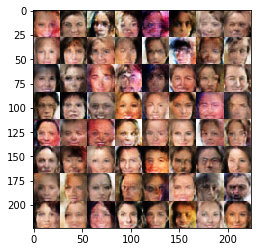

Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 4.2882
Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 2.2974
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 2.8384
Epoch 1/1... Discriminator Loss: 2.1047... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 3.1866
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.8016
Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 3.4059


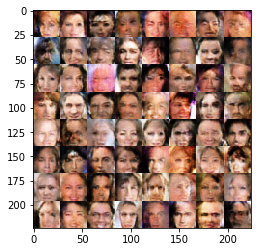

Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 2.0354
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 2.2950
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.9382
Epoch 1/1... Discriminator Loss: 0.2769... Generator Loss: 2.2844
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 2.5795
Epoch 1/1... Discriminator Loss: 0.1111... Generator Loss: 3.8334
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 0.2010... Generator Loss: 2.5110
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.5726


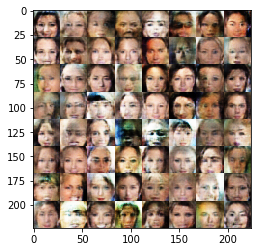

Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.1651... Generator Loss: 3.3073
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.1705... Generator Loss: 3.0367
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 3.2236
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 0.9505


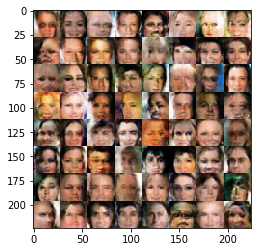

Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 4.2940
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 2.2860
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.4792
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 2.0074
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 2.0864
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 1.9569
Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 2.2107
Epoch 1/1... Discriminator Loss: 2.1017... Generator Loss: 0.2253
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 1.8880


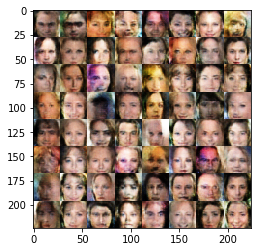

Epoch 1/1... Discriminator Loss: 0.2769... Generator Loss: 2.0796
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 1.8299
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 3.8295
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 4.5499
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 5.9963
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.3474


In [ ]:
batch_size = 64
z_dim = 120
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.